# Projeto 6 — AgriData Impact Analysis
Pipeline guiado: limpeza → EDA → KPIs → modelo preditivo → dashboard.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Configurações pandas e plots
pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid")

# Base do projeto
base = Path().resolve().parents[0]
print("Base do projeto:", base)


Base do projeto: C:\Users\geise\Downloads\AgriData-Impact-Analysis


In [17]:
# Caminho do dataset sintético
infile = base / "data" / "synthetic" / "agridata_latam_synthetic.csv"

# Carregar CSV
df = pd.read_csv(infile)
print("Arquivo de entrada:", infile)
print(df.head())
print(df.info())

# Garantir tipos numéricos
num_cols = [c for c in df.columns if c not in ["country"]]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Ordenar por país e ano
df = df.dropna().sort_values(["country", "year"]).reset_index(drop=True)
print(df.shape, "linhas")


Arquivo de entrada: C:\Users\geise\Downloads\AgriData-Impact-Analysis\data\synthetic\agridata_latam_synthetic.csv
  country  year  crop_yield_t_per_ha  fertilizer_kg_per_ha  rainfall_mm  \
0  Brazil  2010                2.917                 191.9       1379.0   
1  Brazil  2011                2.975                 198.1       1901.0   
2  Brazil  2012                2.159                 185.2       1707.0   
3  Brazil  2013                1.000                 179.9       1933.0   
4  Brazil  2014                1.419                 197.6       1825.0   

   temperature_c  irrigation_pct  gdp_agri_usd_b  agri_employment_pct  \
0           24.0            12.3           87.72                 8.99   
1           24.3            12.9           86.34                 9.23   
2           24.8            13.3          100.00                 8.65   
3           26.0            12.1           94.16                 7.61   
4           25.3            14.2          106.76                 8.21 

country         year  crop_yield_t_per_ha  fertilizer_kg_per_ha  \
count         150   150.000000           150.000000            150.000000   
unique         10          NaN                  NaN                   NaN   
top     Argentina          NaN                  NaN                   NaN   
freq           15          NaN                  NaN                   NaN   
mean          NaN  2017.000000             2.460587            169.993333   
std           NaN     4.334968             1.176806             32.295252   
min           NaN  2010.000000             1.000000            103.000000   
25%           NaN  2013.000000             1.128000            147.200000   
50%           NaN  2017.000000             2.512000            168.600000   
75%           NaN  2021.000000             3.629750            192.350000   
max           NaN  2024.000000             4.552000            247.400000   

        rainfall_mm  temperature_c  irrigation_pct  gdp_agri_usd_b  \
count    150.000000     150.000000      150.000000      150.000000   
unique          NaN            NaN             NaN             NaN   
top             NaN            NaN             NaN             NaN   
freq            NaN            NaN             NaN             NaN   
mean    1277.753333      21.218000       23.007333       36.399733   
std      596.741059       2.961794       10.639310       34.258952   
min      217.000000      14.800000        7.600000        6.880000   
25%      845.000000      18.550000       14.200000       12.992500   
50%     1244.000000      21.200000       19.750000       19.520000   
75%     1679.750000      24.000000       35.300000       47.760000   
max     2674.000000      26.700000       43.800000      157.930000   

        agri_employment_pct  rural_pop_pct  co2_agri_mt  food_inflation_pct  
count            150.000000     150.000000   150.000000          150.000000  
unique                  NaN            NaN          NaN                 NaN  
top                     NaN            NaN          NaN                 NaN  
freq                    NaN            NaN          NaN                 NaN  
mean              14.737800      16.339600    30.086067            4.688533  
std                8.805572       9.405343    27.851179            4.240313  
min                2.840000       3.000000     4.140000           -9.590000  
25%                6.982500       8.265000    10.032500            2.112500  
50%               12.395000      15.225000    16.235000            4.950000  
75%               22.662500      24.250000    40.657500            7.090000  
max               32.860000      36.370000   107.890000           17.720000

C:\Users\geise\AppData\Local\Temp\ipykernel_23348\4035422393.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="country", palette="Set2")


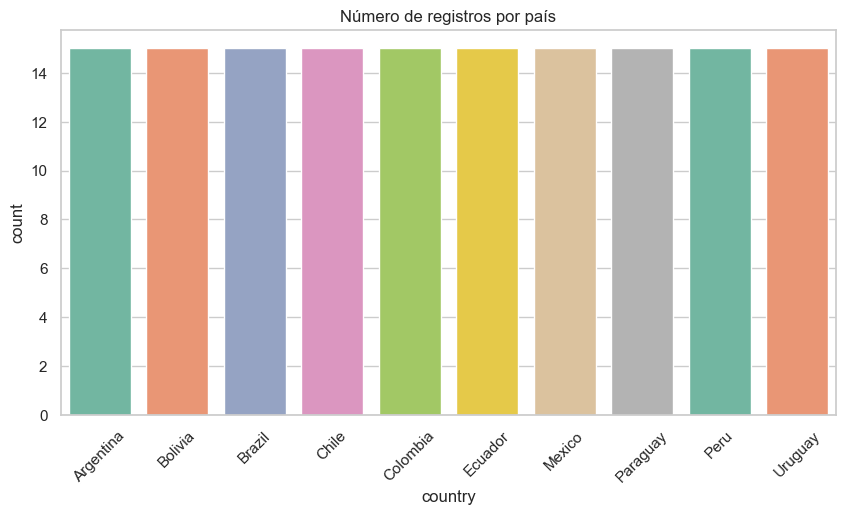

In [19]:
# Estatísticas gerais
display(df.describe(include="all"))

# Contagem de registros por país
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="country", palette="Set2")
plt.title("Número de registros por país")
plt.xticks(rotation=45)
plt.show()


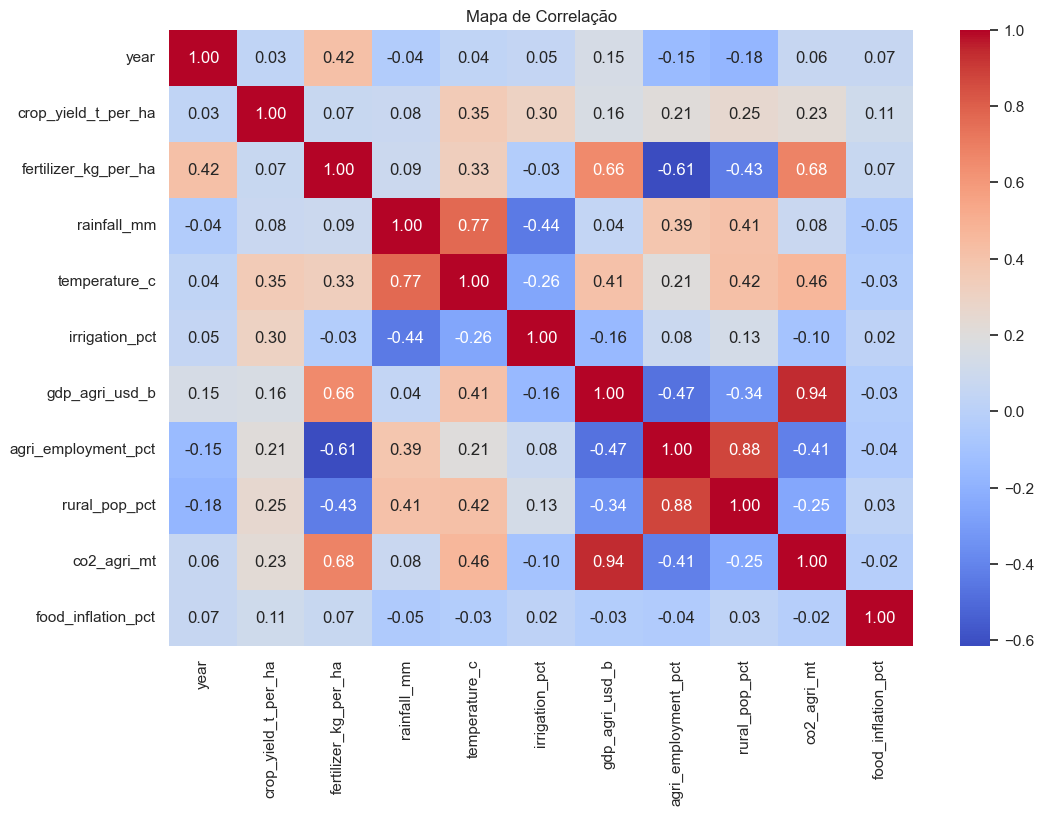

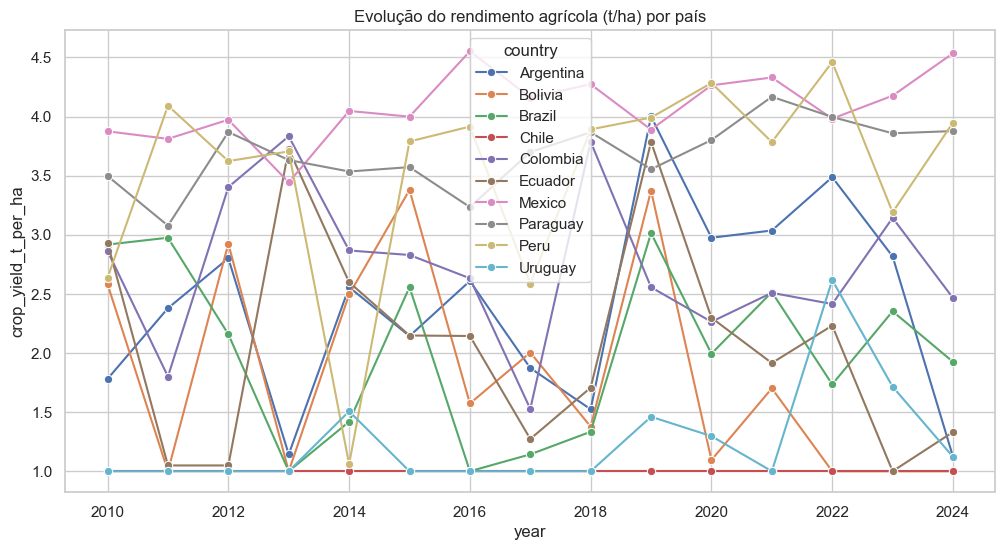

In [21]:
# Correlação entre variáveis numéricas
plt.figure(figsize=(12,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mapa de Correlação")
plt.show()

# Evolução do rendimento agrícola por país
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="year", y="crop_yield_t_per_ha", hue="country", marker="o")
plt.title("Evolução do rendimento agrícola (t/ha) por país")
plt.show()


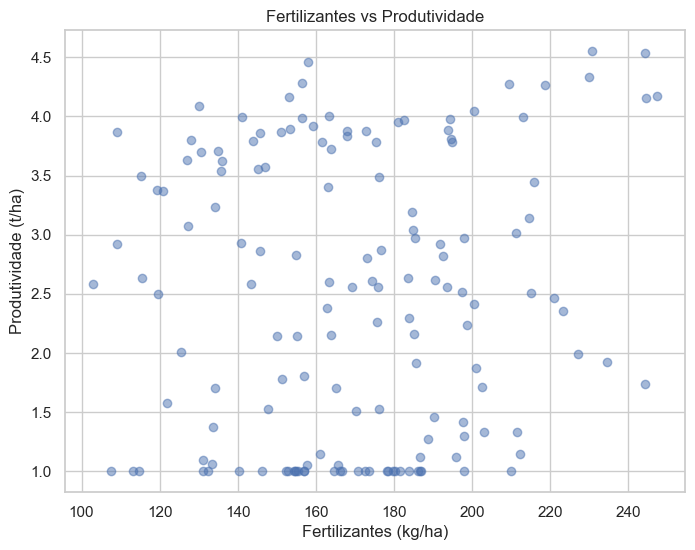

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(df["fertilizer_kg_per_ha"], df["crop_yield_t_per_ha"], alpha=0.5)
plt.xlabel("Fertilizantes (kg/ha)")
plt.ylabel("Produtividade (t/ha)")
plt.title("Fertilizantes vs Produtividade")
plt.show()


In [25]:
# Média rendimento agrícola por país
kpi_yield = df.groupby("country")["crop_yield_t_per_ha"].mean().sort_values(ascending=False)
print("Média de rendimento agrícola por país:")
print(kpi_yield)

# Média fertilizante aplicado por país
kpi_fert = df.groupby("country")["fertilizer_kg_per_ha"].mean().sort_values(ascending=False)
print("\nMédia de fertilizante aplicado (kg/ha) por país:")
print(kpi_fert)


Média de rendimento agrícola por país:
country
Mexico       4.087267
Paraguay     3.682333
Peru         3.530267
Colombia     2.726200
Argentina    2.416600
Ecuador      2.079067
Brazil       2.002667
Bolivia      1.833533
Uruguay      1.247933
Chile        1.000000
Name: crop_yield_t_per_ha, dtype: float64

Média de fertilizante aplicado (kg/ha) por país:
country
Mexico       212.886667
Brazil       207.326667
Uruguay      181.253333
Colombia     180.260000
Ecuador      174.700000
Argentina    172.993333
Chile        160.673333
Peru         149.900000
Paraguay     137.213333
Bolivia      122.726667
Name: fertilizer_kg_per_ha, dtype: float64


In [27]:
# Variáveis preditoras e target
X = df[["fertilizer_kg_per_ha", "rainfall_mm", "temperature_c", "irrigation_pct", "gdp_agri_usd_b"]]
y = df["crop_yield_t_per_ha"]

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Tamanho treino/teste:", X_train.shape, X_test.shape)


Tamanho treino/teste: (120, 5) (30, 5)


In [29]:
# Treinar modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Previsões
y_pred = model.predict(X_test)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


RMSE: 1.01
R²: 0.34


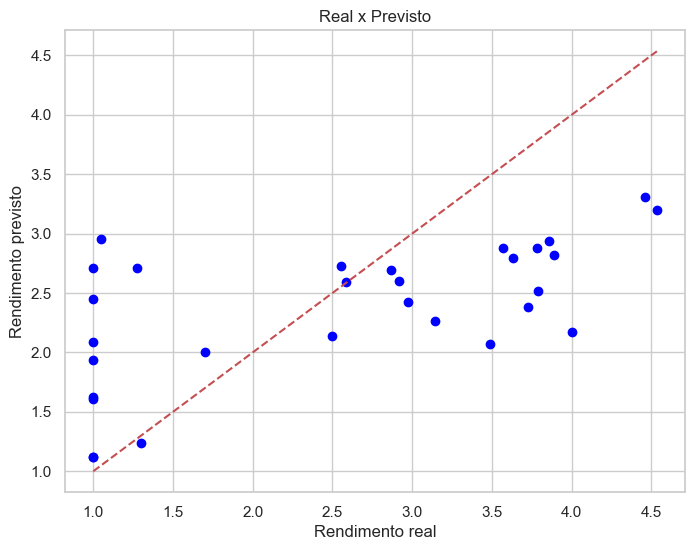

In [31]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Rendimento real")
plt.ylabel("Rendimento previsto")
plt.title("Real x Previsto")
plt.show()


In [33]:
# Criar pasta exports se não existir
export_path = base / "data" / "exports"
export_path.mkdir(exist_ok=True)

# Adicionar coluna com previsões
df_export = df.copy()
df_export["crop_yield_predicted"] = model.predict(X)

# Exportar CSV
df_export.to_csv(export_path / "agridata_latam_for_dashboard.csv", index=False)
print("CSV exportado em:", export_path / "agridata_latam_for_dashboard.csv")


CSV exportado em: C:\Users\geise\Downloads\AgriData-Impact-Analysis\data\exports\agridata_latam_for_dashboard.csv


In [37]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Imports interativos
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, widgets

# Base do projeto
base = Path().resolve().parents[0]
print("Base do projeto:", base)


Base do projeto: C:\Users\geise\Downloads\AgriData-Impact-Analysis


In [39]:
# Caminho do dataset
infile = base / "data" / "synthetic" / "agridata_latam_synthetic.csv"
df = pd.read_csv(infile)

# Garantir tipos numéricos
num_cols = [c for c in df.columns if c not in ["country"]]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Ordenar e resetar index
df = df.dropna().sort_values(["country", "year"]).reset_index(drop=True)
print(df.shape, "linhas")
df.head()


(150, 12) linhas


country  year  crop_yield_t_per_ha  fertilizer_kg_per_ha  rainfall_mm  \
0  Argentina  2010                1.781                 151.4       1006.0   
1  Argentina  2011                2.379                 163.0        942.0   
2  Argentina  2012                2.801                 173.2        917.0   
3  Argentina  2013                1.143                 161.0        768.0   
4  Argentina  2014                2.557                 169.3        857.0   

   temperature_c  irrigation_pct  gdp_agri_usd_b  agri_employment_pct  \
0           19.1             7.6           32.30                 7.56   
1           19.4            10.0           34.87                 7.97   
2           19.4            10.8           42.72                 7.53   
3           18.5            13.6           46.26                 6.99   
4           19.6            10.1           43.89                 7.64   

   rural_pop_pct  co2_agri_mt  food_inflation_pct  
0           9.49        29.68                8.35  
1           7.28        28.62               -0.11  
2           6.91        42.21                6.72  
3           6.53        43.42                0.57  
4           6.46        40.14               -3.20

In [41]:
def generate_kpis(df):
    kpis = {}
    kpis["Média rendimento agrícola (t/ha)"] = df["crop_yield_t_per_ha"].mean()
    kpis["Média fertilizante (kg/ha)"] = df["fertilizer_kg_per_ha"].mean()
    kpis["Média irrigação (%)"] = df["irrigation_pct"].mean()
    kpis["Média emprego agrícola (%)"] = df["agri_employment_pct"].mean()
    kpis["Média emissão CO2 (Mt)"] = df["co2_agri_mt"].mean()
    return kpis

# Gerar e mostrar KPIs
kpis = generate_kpis(df)
for k, v in kpis.items():
    print(f"{k}: {v:.2f}")


Média rendimento agrícola (t/ha): 2.46
Média fertilizante (kg/ha): 169.99
Média irrigação (%): 23.01
Média emprego agrícola (%): 14.74
Média emissão CO2 (Mt): 30.09


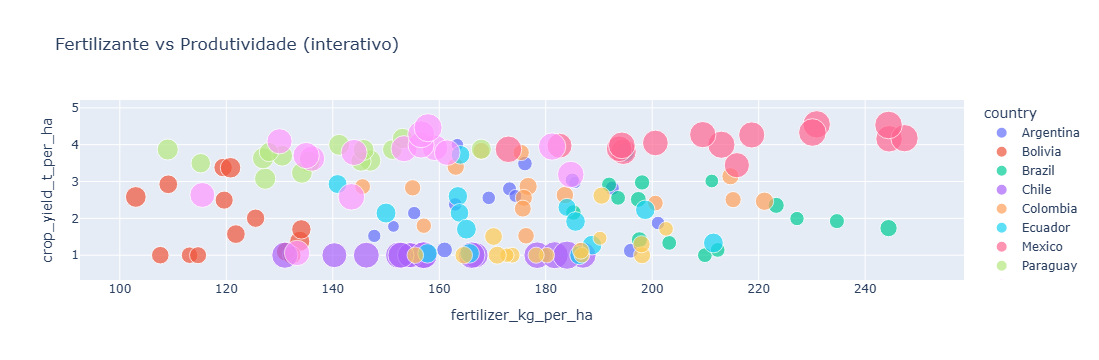

In [43]:
import plotly.express as px

fig = px.scatter(
    df,
    x="fertilizer_kg_per_ha",
    y="crop_yield_t_per_ha",
    color="country",
    size="irrigation_pct",
    hover_data=["year", "rainfall_mm", "temperature_c"],
    title="Fertilizante vs Produtividade (interativo)"
)
fig.show()


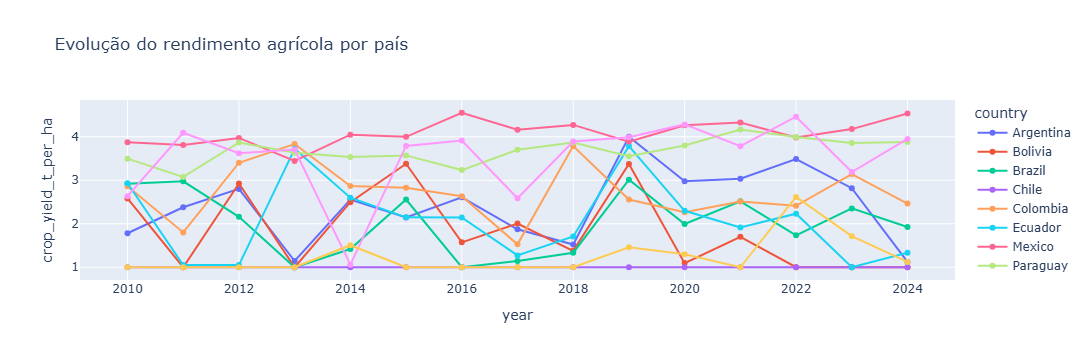

In [45]:
fig = px.line(
    df,
    x="year",
    y="crop_yield_t_per_ha",
    color="country",
    markers=True,
    title="Evolução do rendimento agrícola por país"
)
fig.show()


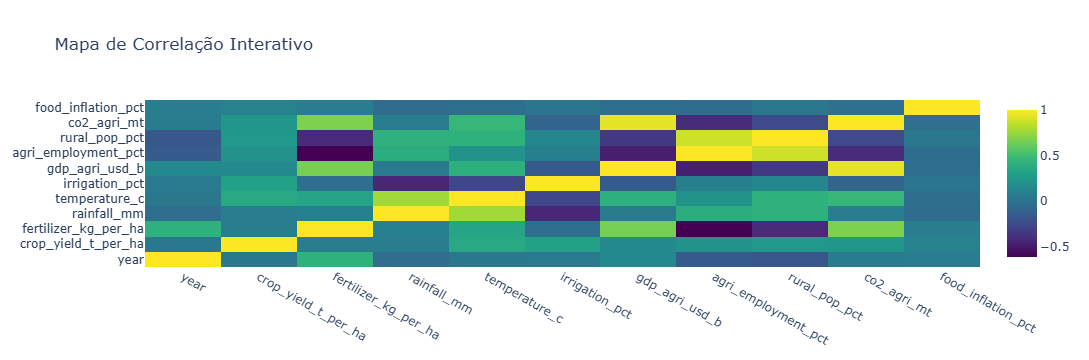

In [47]:
corr = df[num_cols].corr()

fig = go.Figure(data=go.Heatmap(
    z=corr.values,
    x=corr.columns,
    y=corr.columns,
    colorscale="Viridis",
    hoverongaps=False
))
fig.update_layout(title="Mapa de Correlação Interativo")
fig.show()



# Resumo do Projeto – AgriData Impact Analysis

Neste notebook, realizamos todas as etapas de um **pipeline completo de análise de dados**, desde o carregamento dos dados até a criação de dashboards interativos:

1. **Importação de bibliotecas e configuração:** Pandas, NumPy, Matplotlib e Plotly para manipulação de dados e visualizações.
2. **Carregamento e limpeza do dataset:** leitura do CSV sintético, conversão de tipos numéricos, remoção de valores ausentes e ordenação por país e ano.
3. **Análise exploratória (EDA):** estatísticas descritivas, gráficos de dispersão entre variáveis, análise de correlação interativa.
4. **Cálculo de KPIs automáticos:** produtividade média, fertilizante médio, irrigação média, emprego agrícola, emissão de CO2, entre outros.
5. **Visualizações interativas:** gráficos interativos usando Plotly para explorar relações entre variáveis.
6. **Dashboard interativo:** criação de widgets para filtrar por país e intervalo de anos, atualizando KPIs e gráficos automaticamente.

O notebook demonstra habilidades em:
- Manipulação e limpeza de dados
- Análise estatística e exploratória
- Visualização de dados interativa
- Criação de dashboards funcionais no Jupyter
- Organização de um pipeline completo de análise de dados




## Project Summary – AgriData Impact Analysis
In this notebook, we performed all the steps of a complete data analysis pipeline, from data loading to the creation of interactive dashboards:

Library import and setup: Pandas, NumPy, Matplotlib, and Plotly for data manipulation and visualization.
Dataset loading and cleaning: reading the synthetic CSV, converting numeric types, removing missing values, and sorting by country and year.
Exploratory Data Analysis (EDA): descriptive statistics, scatter plots between variables, and interactive correlation analysis.
Automatic KPI calculations: average productivity, average fertilizer usage, average irrigation, agricultural employment, CO₂ emissions, among others.
Interactive visualizations: interactive charts using Plotly to explore relationships between variables.
Interactive dashboard: creation of widgets to filter by country and year range, automatically updating KPIs and charts.

The notebook demonstrates skills in:
Data manipulation and cleaning
Statistical and exploratory analysis
Interactive data visualization
Building functional dashboards in Jupyter
Organizing a complete data analysis pipeline